## CRISP-DM Project - Seattle Air bnb



How many listings data in listings.csv - 3818 , How many host in listings.csv - 2751
-------------------------------------------------------------------------------------------
calendar.csv dataset contains 1393570 rows.
The first date of observation is 2016-01-04 and the last date is 2017-01-02.
-------------------------------------------------------------------------------------------
reviews.csv dataset contains 84849 rows.
The first date of observation is 2009-06-07 and the last date is 2016-01-03.
-------------------------------------------------------------------------------------------


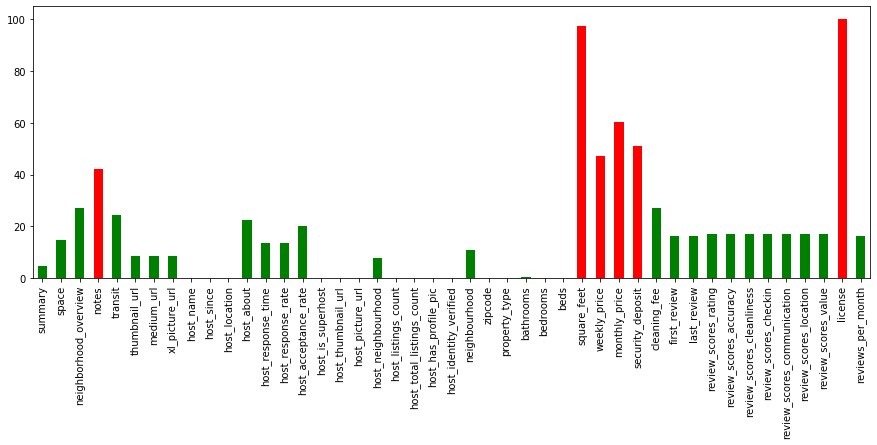

In [4]:
# Import statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import seaborn as sns

%matplotlib inline

import helpper as user_func # customized fuctions
import variable_pre_define as pre_var  # pre-defined variables

listings_df = pd.read_csv('listings.csv')
calendar_df = pd.read_csv('calendar.csv')
reviews_df = pd.read_csv('reviews.csv')

listings_num = listings_df.id.count()
host_num = len(listings_df.host_id.unique())

print('How many listings data in listings.csv - {} , How many host in listings.csv - {}'.format(listings_num, host_num))
print('-------------------------------------------------------------------------------------------')

rows_num = calendar_df.shape[0]
min_date = calendar_df['date'].min()
max_date = calendar_df['date'].max()

print('calendar.csv dataset contains %d rows.' % (rows_num))
print('The first date of observation is %s and the last date is %s.' % (min_date, max_date))

print('-------------------------------------------------------------------------------------------')

rows_num = reviews_df.shape[0]
min_date = reviews_df['date'].min()
max_date = reviews_df['date'].max()

print('reviews.csv dataset contains %d rows.' % (rows_num))
print('The first date of observation is %s and the last date is %s.' % (min_date, max_date))
print('-------------------------------------------------------------------------------------------')

# Visualize the NA values percent from each columns
# Drop column which has more 40% NA value proportion
listings_df_cleaned = user_func.drop_col_NA_ratio(listings_df, 40)

# "id" colum rename as "listing_id" for merge others if we need.
listings_df_cleaned.rename(columns={'id':'listing_id'}, inplace = True)

# Drop the columns which defined as cadidate to drop column (refer to "variable_pre_defined.py")
listings_df_cleaned.drop(pre_var.drop_col, axis=1, inplace =True)

# Drop columns which has a name include 'url'. we don't need url info.
listings_df_cleaned.drop(listings_df[[col for col in listings_df.columns if 'url' in col]], axis = 1, inplace=True)

# Drop the rows which has NA at review associated columns(refer to "variable_pre_defined.py") with reset_index
# 2019.11.02 review feature in listings_df is important. that can be final result as Y value on some research
listings_df_cleaned = listings_df_cleaned.dropna(subset = pre_var.review_eval_col,axis =0).reset_index(drop = True)

# Extract info from columns associated with price "$", data cleanning (str > float)
price_col_name= [col for col in listings_df_cleaned.columns
                     if 
                 ('price' in col) or 
                 ('deposit' in col) or 
                 ('cleaning_fee' in col) or 
                 ('extra_people' in col)
                ]
listings_df_cleaned.loc[:,price_col_name] = listings_df_cleaned[price_col_name].replace(regex=[r'[$,]'], value='').astype(float)

# Extract information from columns associated with rate "%", data cleaning (str > float)
rate_col_name = [col for col in listings_df_cleaned.columns if 'rate' in col]
listings_df_cleaned.loc[:,rate_col_name] = listings_df_cleaned[rate_col_name].replace(regex=[r'[%]'], value='').astype(float)

# Extract information from calendar_updated, data cleaning (str > int(Days))
listings_df_cleaned.loc[:,'calendar_updated'] = listings_df_cleaned.calendar_updated.map(user_func.calendar_updated_convert)

# Extract information from pre-defined "bool_col_name", data cleaning (str > int(0(Flase) or 1(True)))
for col in pre_var.bool_col_name:
    listings_df_cleaned.loc[:,col] = listings_df_cleaned[col].map(pre_var.dic_bool)

# Extract information from pre-defined "cat_col_name", data cleaning
for col in pre_var.cat_col_name:
    listings_df_cleaned.loc[:,col] = listings_df_cleaned[col].map(pre_var.dic_cat)

# "host_response_time" column move to from cat_col_name to num_col_name    
pre_var.cat_col_name = pre_var.cat_col_name[1:] 
pre_var.num_col_name.append('host_response_time')

# One Hot Encode for Categorical variable
listings_df_cleaned = user_func.create_dummies(listings_df_cleaned, columns = pre_var.cat_col_name)
listings_df_cleaned.drop(pre_var.cat_col_name, axis=1, inplace = True)

# "amenities" column data pre-process and One Hot encode
listings_df_cleaned.loc[:,'amenities'] = listings_df_cleaned.amenities.replace(regex=r'(?:{|}|")',value='')
listings_df_cleaned.loc[:,'amenities_count'] = listings_df_cleaned.amenities.map(lambda x : len(x.split(',')))
amenities = np.unique(np.concatenate(listings_df_cleaned.amenities.map(lambda x:x.split(',')).values))
amenitis_mat = np.array([listings_df_cleaned.amenities.map(lambda amns: amn in amns).values for amn in amenities])
amenities_processed_df = pd.DataFrame(data = amenitis_mat.T, columns = amenities)                      
listings_amenities= pd.concat([amenities_processed_df,listings_df_cleaned.listing_id], axis=1)
listings_amenities=listings_amenities.drop("",axis=1)
listings_amenities_melt = listings_amenities.melt(id_vars = ['listing_id'], var_name ='amenity')
listings_amenities_melt = listings_amenities_melt.assign(
    amenity_modified = listings_amenities_melt.amenity.replace(pre_var.dict_amenities_catagorize)
)
listings_amenities_pivot = listings_amenities_melt.pivot_table(
    index='listing_id',
    columns='amenity_modified',
    values='value', 
    aggfunc='max'
)
listings_joined=listings_df_cleaned.join(listings_amenities_pivot,on="listing_id",how="inner")
listings_joined.drop(['amenities'], axis =1, inplace =True)

# Host_since column data type change from str to datetime
listings_joined.loc[:,'host_since'] = pd.to_datetime(listings_joined['host_since'])
    

# Impute data
col_imp_0 = [
    'bathrooms',
    'bedrooms',
    'cleaning_fee'
]

col_imp_mode = [
    'host_acceptance_rate',
    'host_response_rate',   
    'host_response_time'
]

listings_joined.loc[:,col_imp_0] = user_func.impute_to_series(listings_joined[col_imp_0],'0')
listings_joined.loc[:,col_imp_mode] = user_func.impute_to_series(listings_joined[col_imp_mode],'mode')



Index(['listing_id', 'host_id', 'host_since', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'is_location_exact',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'price', 'cleaning_fee', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'calendar_updated',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_c

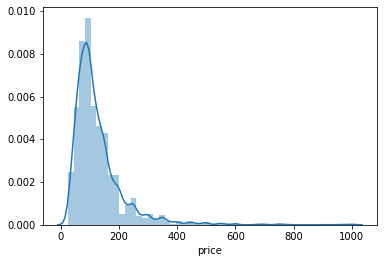

In [18]:
listings_complete = listings_joined.drop(pre_var.str_col_name[:-1], axis =1).copy()
sns.distplot(listings_complete.price)

In [15]:
listings_complete.columns

Index(['listing_id', 'host_id', 'host_since', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'is_location_exact',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'price', 'cleaning_fee', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'calendar_updated',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_c

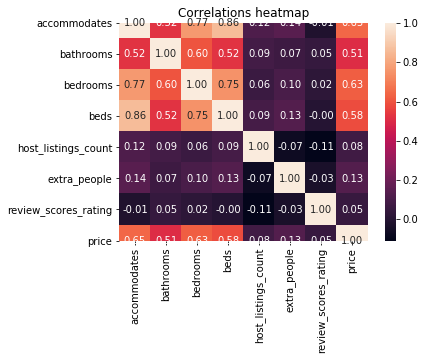

In [12]:
#Find out correlation between columns and plot
corrs = np.corrcoef(listings_complete[cols].values.T)
hm=sns.heatmap(corrs, cbar = True, annot=True, square = True, fmt = '.2f',
              yticklabels = cols, xticklabels = cols).set_title('Correlations heatmap')

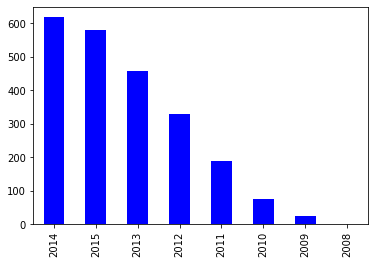

In [14]:
host_since = pd.DataFrame(listings_complete[['host_since','host_id']].groupby(['host_id']).first())
host_since.host_since.map(lambda x : x.year).value_counts().plot.bar(color = ['b','b','b','b','b','b','b','r','b'])
plt.show()

- irrelevant columns candidate list

| Columns Name  | Reason of irrelevance |
| ------------- |-------------|
| name | hosted house title  |
| summary | description column |
| space | description column |
| description | description column |
| experiences_offered | value is only "none" |
| neighborhood_overview | description colum  |
| transit | description column |
| street | street address |
| neighbourhood | name of neighbourhood - we gonna use neighbourhood_group_cleansed or neighbourhood_group_cleansed if we need |
| city | name of city, most data value is 'Seattle' or similiar so usless |
| state | name of state, all value is 'WA' or 'wa'|
| zipcode | useless for anaysis |
| market | market name, All data value is 'Seattle' |
| smart_location | city and state name, most data is 'Seattle, WA' |
| country_code | All data is 'US' |
| country | All data is 'United States' |
| has_availability | All data is 't' |
| availability_30 | |
| availability_60 | |
| availability_90 | |
| availability_365 | |
| calendar_last_scraped | All data is '2016-01-04' |
| requires_license | All data is 't' |
| jurisdiction_names | All data is 'WASHINGTON' |

In [8]:
df_num_lst = df_listings.select_dtypes(include=['int64', 'float64']).copy()
df_cat_lst = df_listings.select_dtypes(include=['object']).copy()

NameError: name 'df_listings' is not defined

In [65]:
listings_df_cleaned.calendar_updated.name

'calendar_updated'

Text(0, 0.5, 'count')

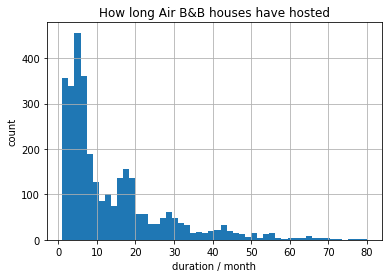

In [23]:
df_num_lst['op_duration_month'] = df_num_lst['number_of_reviews'] / df_num_lst['reviews_per_month']
df_num_lst.op_duration_month.hist(bins =50)
plt.title('How long Air B&B houses have hosted')
plt.xlabel('duration / month')
plt.ylabel('count')

most of house is for under 2-people